In [17]:
from mynn import *
prefix = "random-250-300/"
θ, κ = preprocess_data(prefix)
θ_train, κ_train = θ[0::2], κ[:, :,  0::2]
θ_test, κ_test = θ[1::2], κ[:, :,  1::2]

# θ_test, κ_test = θ[0::2], κ[:, :,  0::2]

coeff_scale = 100.0
# θ_test, κ_test = θ[0::2], κ[:, :,  0::2]



data_svd, bases, N_trunc = build_bases(κ_train, acc=0.99)


x_train = torch.from_numpy(θ_train.astype(np.float32))
y_train = torch.from_numpy(data_svd.astype(np.float32)*coeff_scale)

N_trunc =  9


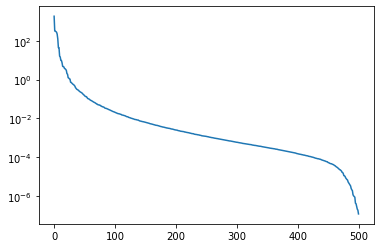

In [2]:
N_x, N_y, N_data = κ_train.shape
data = κ.reshape((-1, N_data))
# svd bases
u, s, vh = np.linalg.svd(np.transpose(data))

plt.semilogy(s)

In [8]:
N_θ = 8
model = DirectKernelRomNet(N_θ, N_trunc)

model = torch.load("DirectKernelRomNet.model")

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


n_epochs = 500000
for epoch in range(n_epochs):
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train) * 1000

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelRomNet.model")

	
# save the model
torch.save(model, "DirectKernelRomNet.model")

[0/500000], loss: 3597.213
[10000/500000], loss: 4904.365
[20000/500000], loss: 3216.863
[30000/500000], loss: 3060.516
[40000/500000], loss: 5394.013
[50000/500000], loss: 2936.447
[60000/500000], loss: 3245.224
[70000/500000], loss: 2810.44
[80000/500000], loss: 3102.524
[90000/500000], loss: 17787.303
[100000/500000], loss: 8227.382
[110000/500000], loss: 2707.989
[120000/500000], loss: 2670.768
[130000/500000], loss: 4722.017
[140000/500000], loss: 25876.068
[150000/500000], loss: 2637.749
[160000/500000], loss: 11181.03
[170000/500000], loss: 3374.248
[180000/500000], loss: 9802.034
[190000/500000], loss: 2991.428
[200000/500000], loss: 4686.645
[210000/500000], loss: 5924.96
[220000/500000], loss: 2341.072
[230000/500000], loss: 2510.899
[240000/500000], loss: 2162.262
[250000/500000], loss: 2497.296
[260000/500000], loss: 2103.174
[270000/500000], loss: 2703.059
[280000/500000], loss: 3727.996
[290000/500000], loss: 1895.217
[300000/500000], loss: 4027.295
[310000/500000], loss:

## Training error 

Average error is  0.005043800188164569


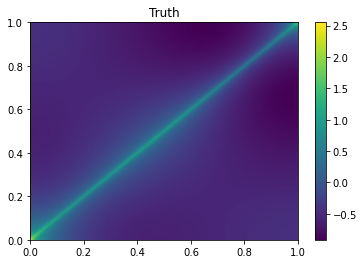

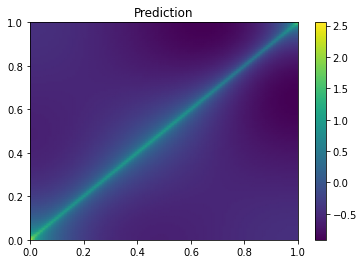

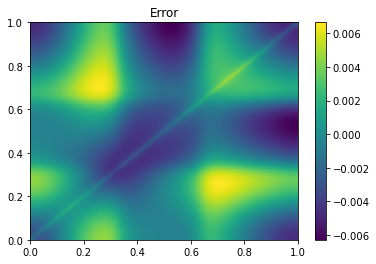

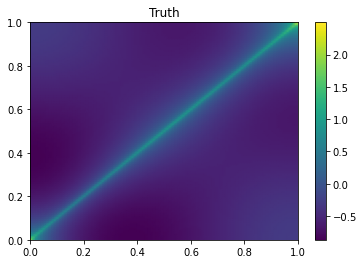

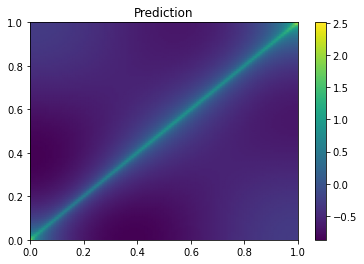

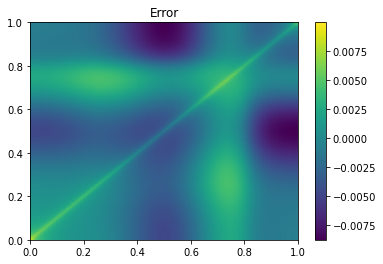

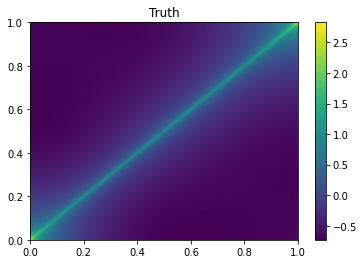

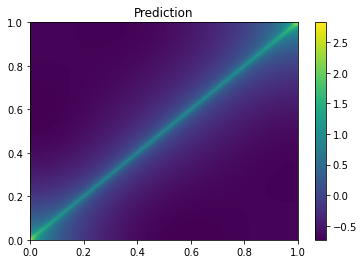

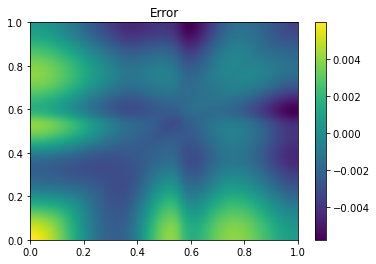

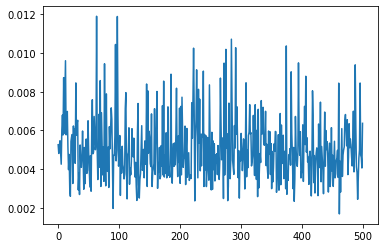

In [21]:
######################################################
N_θ = 8
N_data  =  θ_train.shape
N_x, N_y, N_data = κ_train.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

model = torch.load("DirectKernelRomNet.model")
κ_pred = model(torch.from_numpy(θ_train.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

train_ids = np.arange(0, N_data)
errors = np.zeros(len(train_ids))

for train_id in train_ids:

    errors[train_id] =  np.linalg.norm(κs_pred[:, :, train_id] - κ_train[:, :, train_id])/np.linalg.norm(κ_train[:, :, train_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if train_id %249 == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_train[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % train_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % train_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, train_id] - κ_train[:, :, train_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Average error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)



## Test error 

Average error is  0.14936980307784894


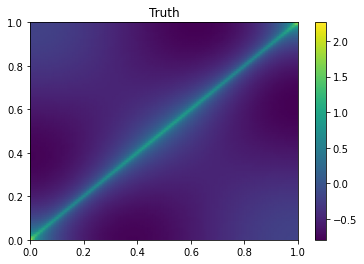

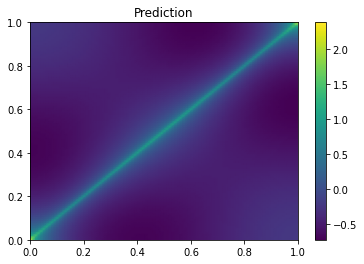

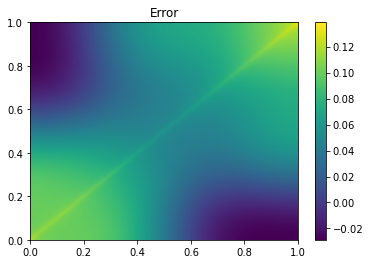

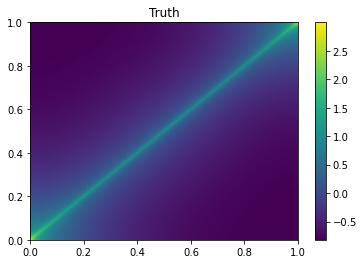

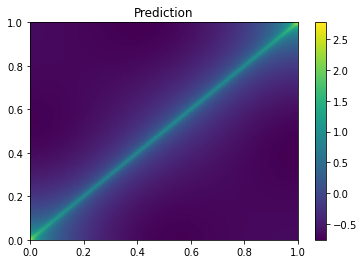

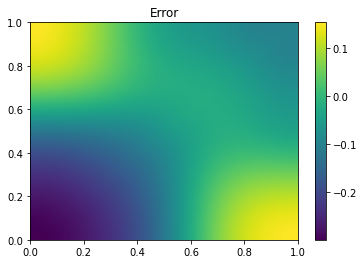

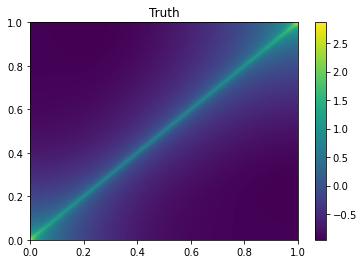

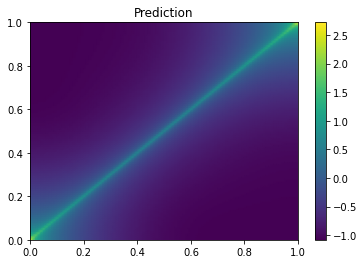

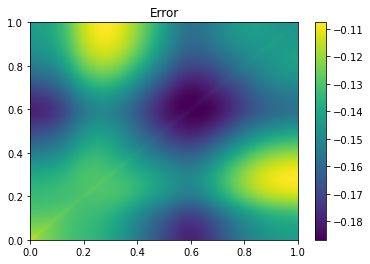

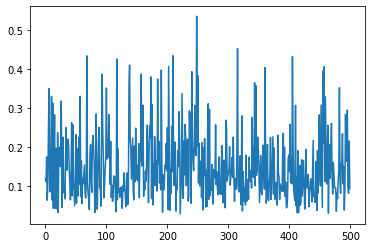

In [22]:
N_θ = 8
N_data  =  θ_test.shape
N_x, N_y, N_data = κ_test.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

model = torch.load("DirectKernelRomNet.model")
κ_pred = model(torch.from_numpy(θ_test.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

test_ids = np.arange(0, N_data)
errors = np.zeros(len(test_ids))

for test_id in test_ids:

    errors[test_id] =  np.linalg.norm(κs_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if test_id %249 == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % test_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id] - κ_test[:, :, test_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Average error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)


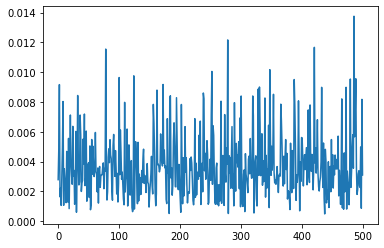

In [23]:
κs = κ_test

# Test projection error
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)


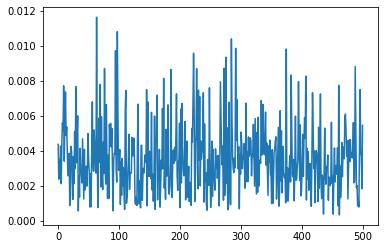

In [24]:
κs = κ_train

# Test projection error
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)

In [7]:
i = 1
κ = κs[:, :, i].reshape(-1)
rom_coeffs = np.dot(bases, κ)/base_norms**2

In [ ]:
rom_coeffs